In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Basic idea of derivatives

In [43]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

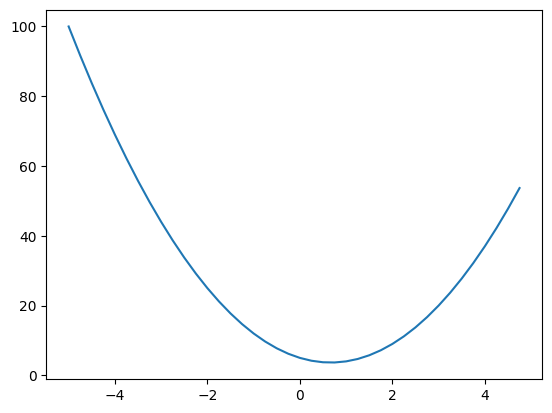

In [44]:
xs = np.arange (-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Derivative represent the direction and magnitude of a slight change in a function:

$L=\lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h}$

In [45]:
h = 0.001
x = 3.0
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

14.00300000000243

The value $14.00300000000243$ is obtained by doing $\frac{\partial}{\partial x}(f(x))=6x-4$

In [46]:
h = 0.001
x = - 3.0
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

-21.996999999998934

In [47]:
h = 0.001
x = 2/3
effect = f(x + h) - f(x)
slope = effect/h #normalised by the value h
slope

0.0029999999995311555

### 1.2 Complex function cases

In [48]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [49]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # the result is -3 which is equal to the derivative b = -3



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


## 2. ```Value``` object

In [50]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    

    
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [51]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [52]:
d._op

'+'

In [53]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %4f}" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

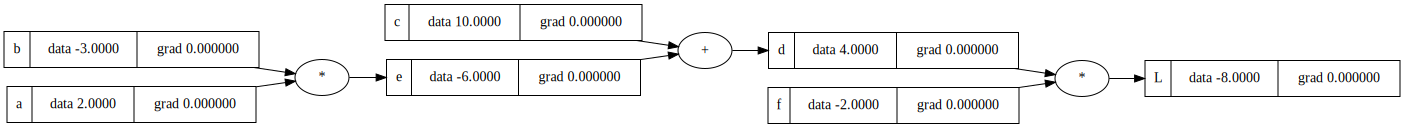

In [54]:
draw_dot(L)

In [62]:
def lol():
    '''
    Quick function to store Value as local and compute derivatives by tweaking 
    where the h is added.
    '''

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label='c')

    e = a*b; e.label = 'e'

    e.data += h
    d = e+c; d.label = 'd'



    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)


lol()



-2.000000000000668


**Manually computing gradient of L w.r.t different functions**

**1. dL/dL**

GIVEN:\
L = d*f

WANT:\
dL / dL = [(d*f + h) - d*f] / h = 1

**2. dL/dd**

GIVEN:\
L = d*f

WANT:\
dL / dd = [(d + h) * f - d * f] / h = f = -2.0

**3. dL/df**
GIVEN:\
L = d*f

WANT:\
dL / dd = [d * (f + h) - d * f] / h = d = 4.0

In [56]:
# Manually updating gradient values
L.grad = 1.0

f.grad = 4.0

d.grad = -2.0

### 2.1 Chain Rule

In **Leibniz's notation**, if a variable $z$ depends on the variable $y$, which itself depends on the variable $x$, then $z$ depends on $x$ as well, via the intermediate variable $y$. Hence:

$\frac{\partial z}{\partial x}=\frac{\partial z}{\partial y}\cdot \frac{\partial y}{\partial x}$

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

**4. dL/dc**

GIVEN:\
d = e+c\
f = Value(-2.0, label='f')\
L = d*f

WANT:\
dL / dc = (dL / dd) * (dd / dc) = -2.0

KNOW:\
dL / dd = f = -2.0\
dd / dc = 1

In [57]:
c.grad = -2.0
e.grad = -2.0

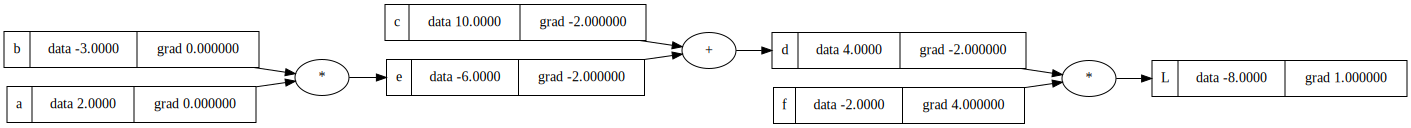

In [58]:
draw_dot(L)

**5. dL / da**

GIVEN:\
e = a * b

WANT:\
dL / de = -2.0 \
de / da = b

dL / da = (dL / de) * (de / da) = -2.0 * b = -2.0 * (-3.0) = 6

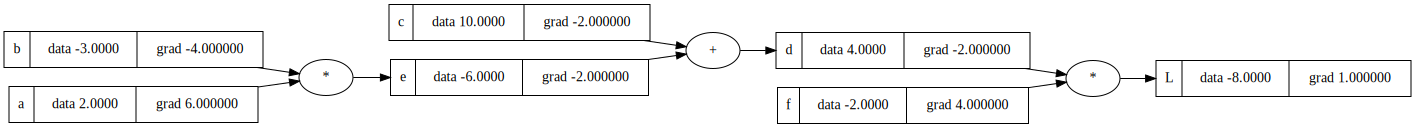

In [63]:
a.grad = 6.0
b.grad = -4.0

draw_dot(L)

Now we test that the cumulative final gradient of L = 1.0 is actually correct,  by slightly increasing all values. We expect F to slight increase as the slope is positive

In [64]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-7.4352)

## 3. Manual backpropagation with a mathematical neuron

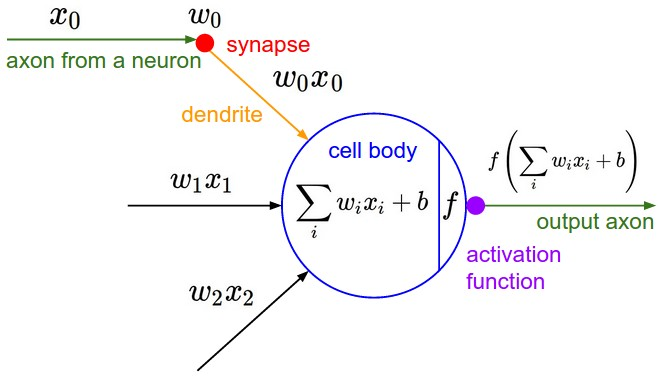

In this graph we can see that:
- $x_i$ represents a raw input = a **neuron**
- At each synapses lies a $w_i$, which represents a weight. The synapse interacts multiplicative with the neurons and send the results to the **cell body** as a **dendrite**
- The cell body has a **bias** $b$, which triggers the function more/less regardless of the inputs
- The cell body gets taken through an activation function, usually a squashing function and returns an output

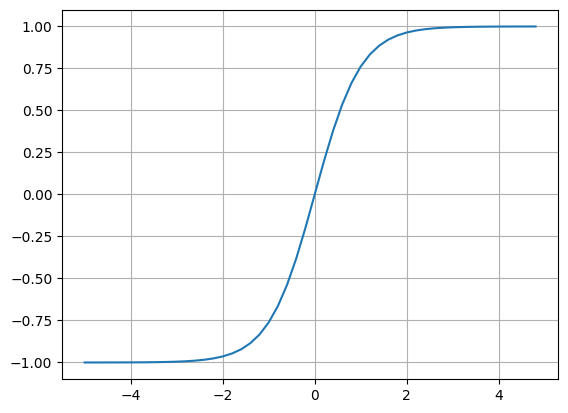

In [ ]:
# Example with hyperbolic tangent

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [72]:
help(np.tanh)

Help on ufunc in module numpy:

tanh = <ufunc 'tanh'>
    tanh(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])

    Compute hyperbolic tangent element-wise.

    Equivalent to ``np.sinh(x)/np.cosh(x)`` or ``-1j * np.tan(1j*x)``.

    Parameters
    ----------
    x : array_like
        Input array.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out` array will retain its original value.
        Note that if an uninitiali

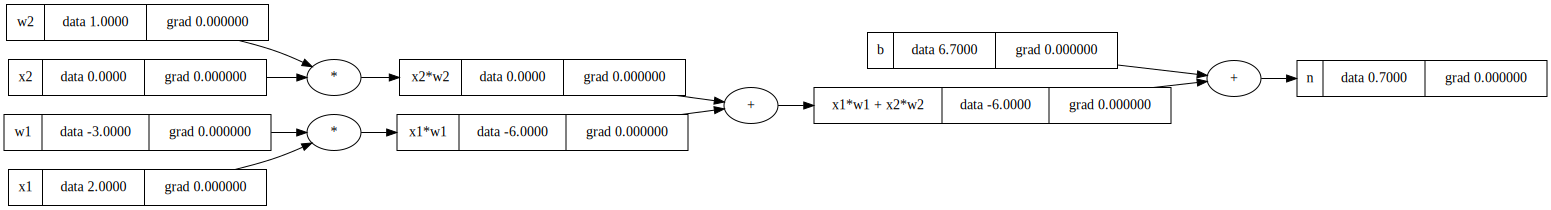

In [70]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body (without activation)
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)


Help on ufunc in module numpy:

tanh = <ufunc 'tanh'>
    tanh(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])

    Compute hyperbolic tangent element-wise.

    Equivalent to ``np.sinh(x)/np.cosh(x)`` or ``-1j * np.tan(1j*x)``.

    Parameters
    ----------
    x : array_like
        Input array.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out` array will retain its original value.
        Note that if an uninitiali